In [1]:
# import pandas

# import modin.pandas as pd
# from modin.config import Engine
# Engine.put("dask") 

In [2]:
import os
import daal4py as d4p
import time
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno

# pio.renderers.default='notebook_connected' 
intel_pal, color=['#0071C5','#FCBB13'], ['#7AB5E1','#FCE7B2']
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), height=500, width=1000))

Total rows in the DataFrame: 5956842


<Axes: >

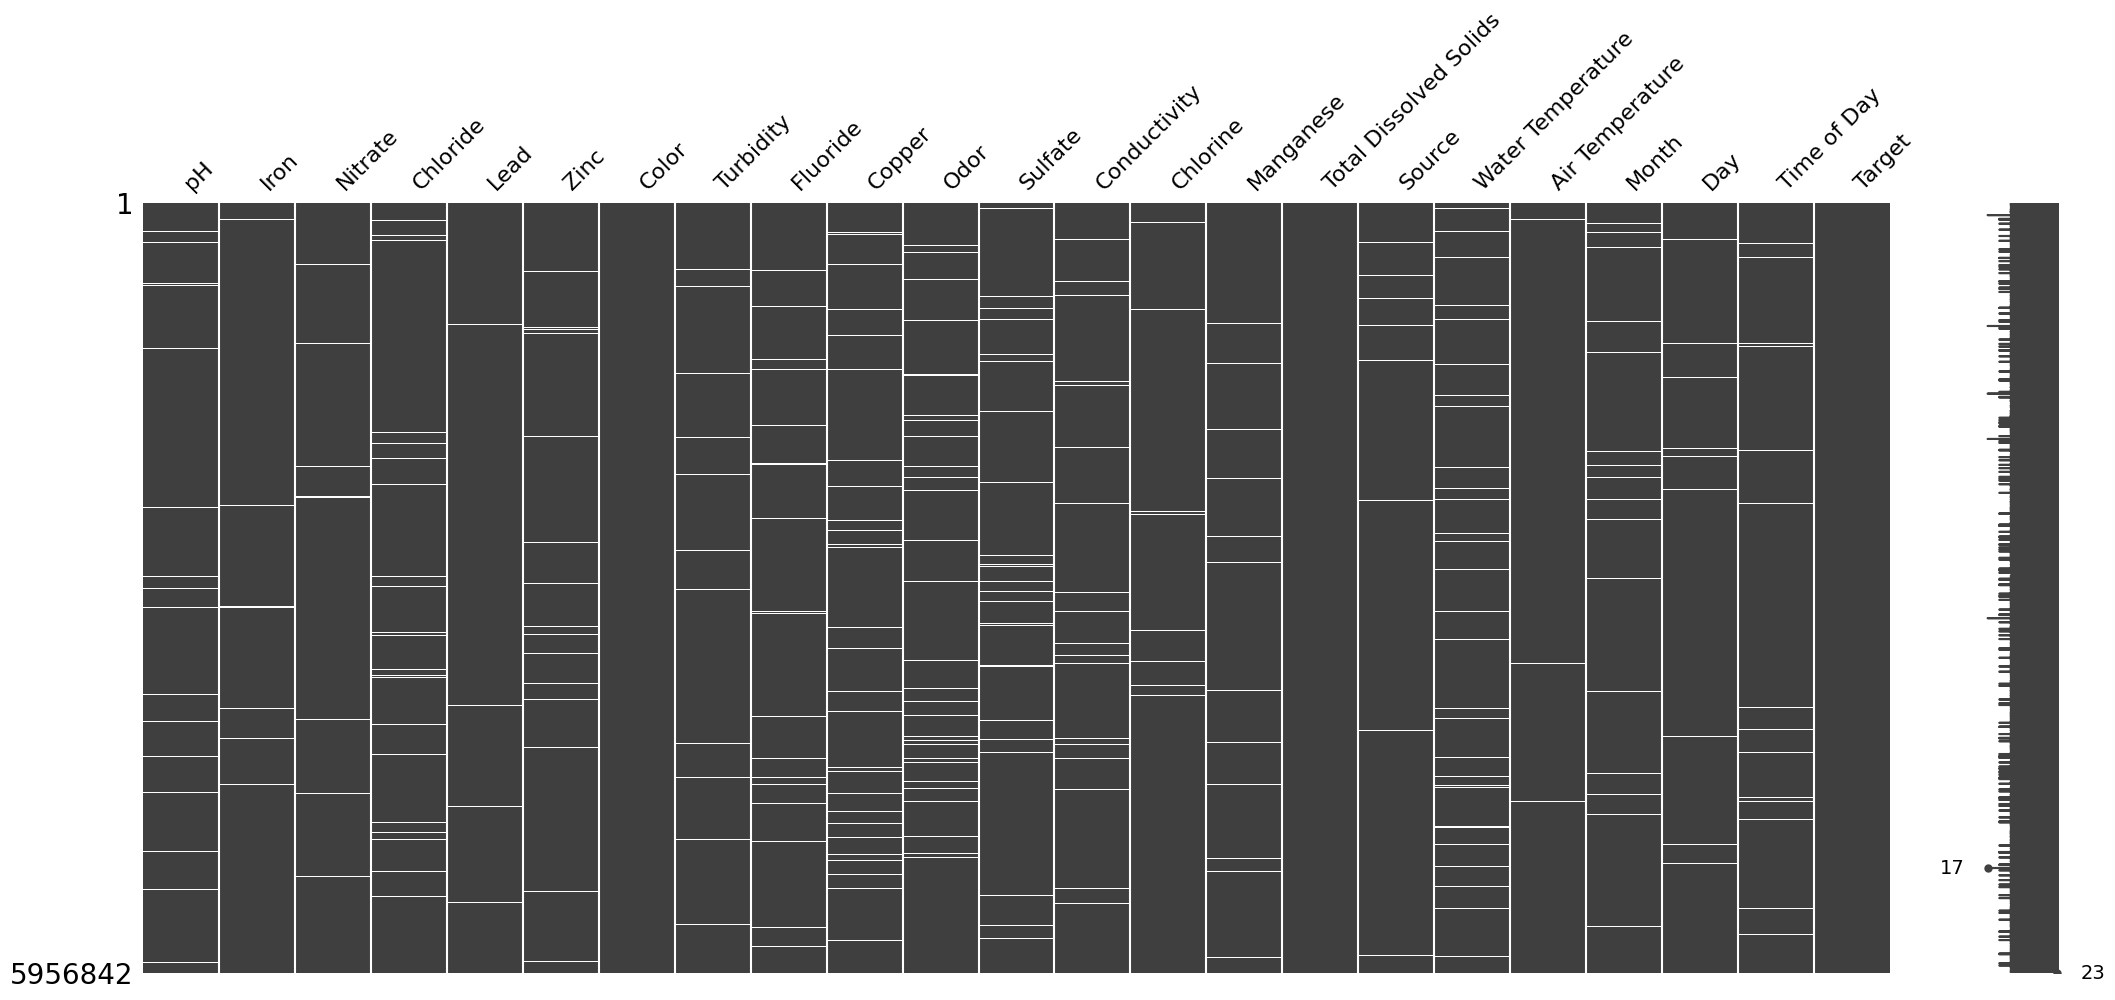

In [3]:
# from distributed import Client
# client = Client()

# data = pd.read_csv("dataset.csv")

data = pd.read_csv("50k_dataset.csv")
data = data.drop('Index', axis=1)
print("Total rows in the DataFrame:", len(data))

# display missing columns
msno.matrix(data)

In [4]:
# handle missing values
start_fill = time.time()
for column in data.columns:
    if data[column].dtype == 'object':
        mode = data[column].mode().iloc[0]
        data[column].fillna(mode, inplace=True)
    else:
        median = data[column].median()
        data[column].fillna(median, inplace=True)

end_fill = time.time()
print("fill missing value took: {:.2f} s".format(end_fill - start_fill))

# drop duplicated rows
data = data.drop_duplicates()

# handle outliers
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    # Calculate 1st and 99th percentiles
    lower, upper = np.percentile(data[col], [1, 99])
    data.loc[data[col] < lower, col] = lower
    data.loc[data[col] > upper, col] = upper

# transform `Color` to number
color_dict = {
    'Colorless': 0,
    'Near Colorless': 1,
    'Faint Yellow': 2,
    'Light Yellow': 3,
    'Yellow': 4
}
data['Color'] = data['Color'].map(color_dict)

# transform `Source` to number
source_dict = {
    'Well': 0,
    'River': 1,
    'Aquifer': 2,
    'Spring': 3,
    'Lake': 4,
    'Stream': 5,
    'Reservoir': 6,
    'Ground': 7
}
data['Source'] = data['Source'].map(source_dict)

mapping = {
    'Color': {v: k for k, v in color_dict.items()},
    'Source': {v: k for k, v in source_dict.items()}
}

fill missing value took: 6.01 s



There are 0 missing values in the data.
There are 0 duplicate records in the data.


pH      Iron   Nitrate    Chloride           Lead      Zinc  Color  \
0  8.332988  0.000083  8.605777  122.799772   3.713298e-52  3.434827      0   
1  6.917863  0.000081  3.734167  227.029851   7.849262e-94  1.245317      2   
2  5.443762  0.020106  3.816994  230.995630   5.286616e-76  0.528280      3   
3  7.955339  0.143988  8.224944  178.129940  3.997118e-176  4.027879      1   
4  8.091909  0.002167  9.925788  186.540872  4.171069e-132  3.807511      3   

   Turbidity  Fluoride    Copper  ...  Chlorine     Manganese  \
0   0.022683  0.607283  0.144599  ...  3.708178  2.269945e-15   
1   0.019007  0.622874  0.437835  ...  3.292038  8.024076e-07   
2   0.319956  0.423423  0.431588  ...  3.560224  7.007989e-02   
3   0.166319  0.208454  0.239451  ...  3.516907  2.468295e-02   
4   0.004867  0.222912  0.616574  ...  3.177849  3.296139e-03   

   Total Dissolved Solids  Source  Water Temperature  Air Temperature  \
0              332.118789       5          16.444276        43.493324   
1              284.641984       4          15.348981        71.220586   
2              566.184673       1          11.643467        44.891330   
3              100.043838       7          10.092392        60.843233   
4              168.075545       3          15.249416        69.336671   

      Month   Day  Time of Day Target  
0   January  29.0          4.0      0  
1  November  26.0         16.0      0  
2   January  31.0          8.0      0  
3     April   1.0         21.0      0  
4      June  29.0          7.0      0  

[5 rows x 23 columns]

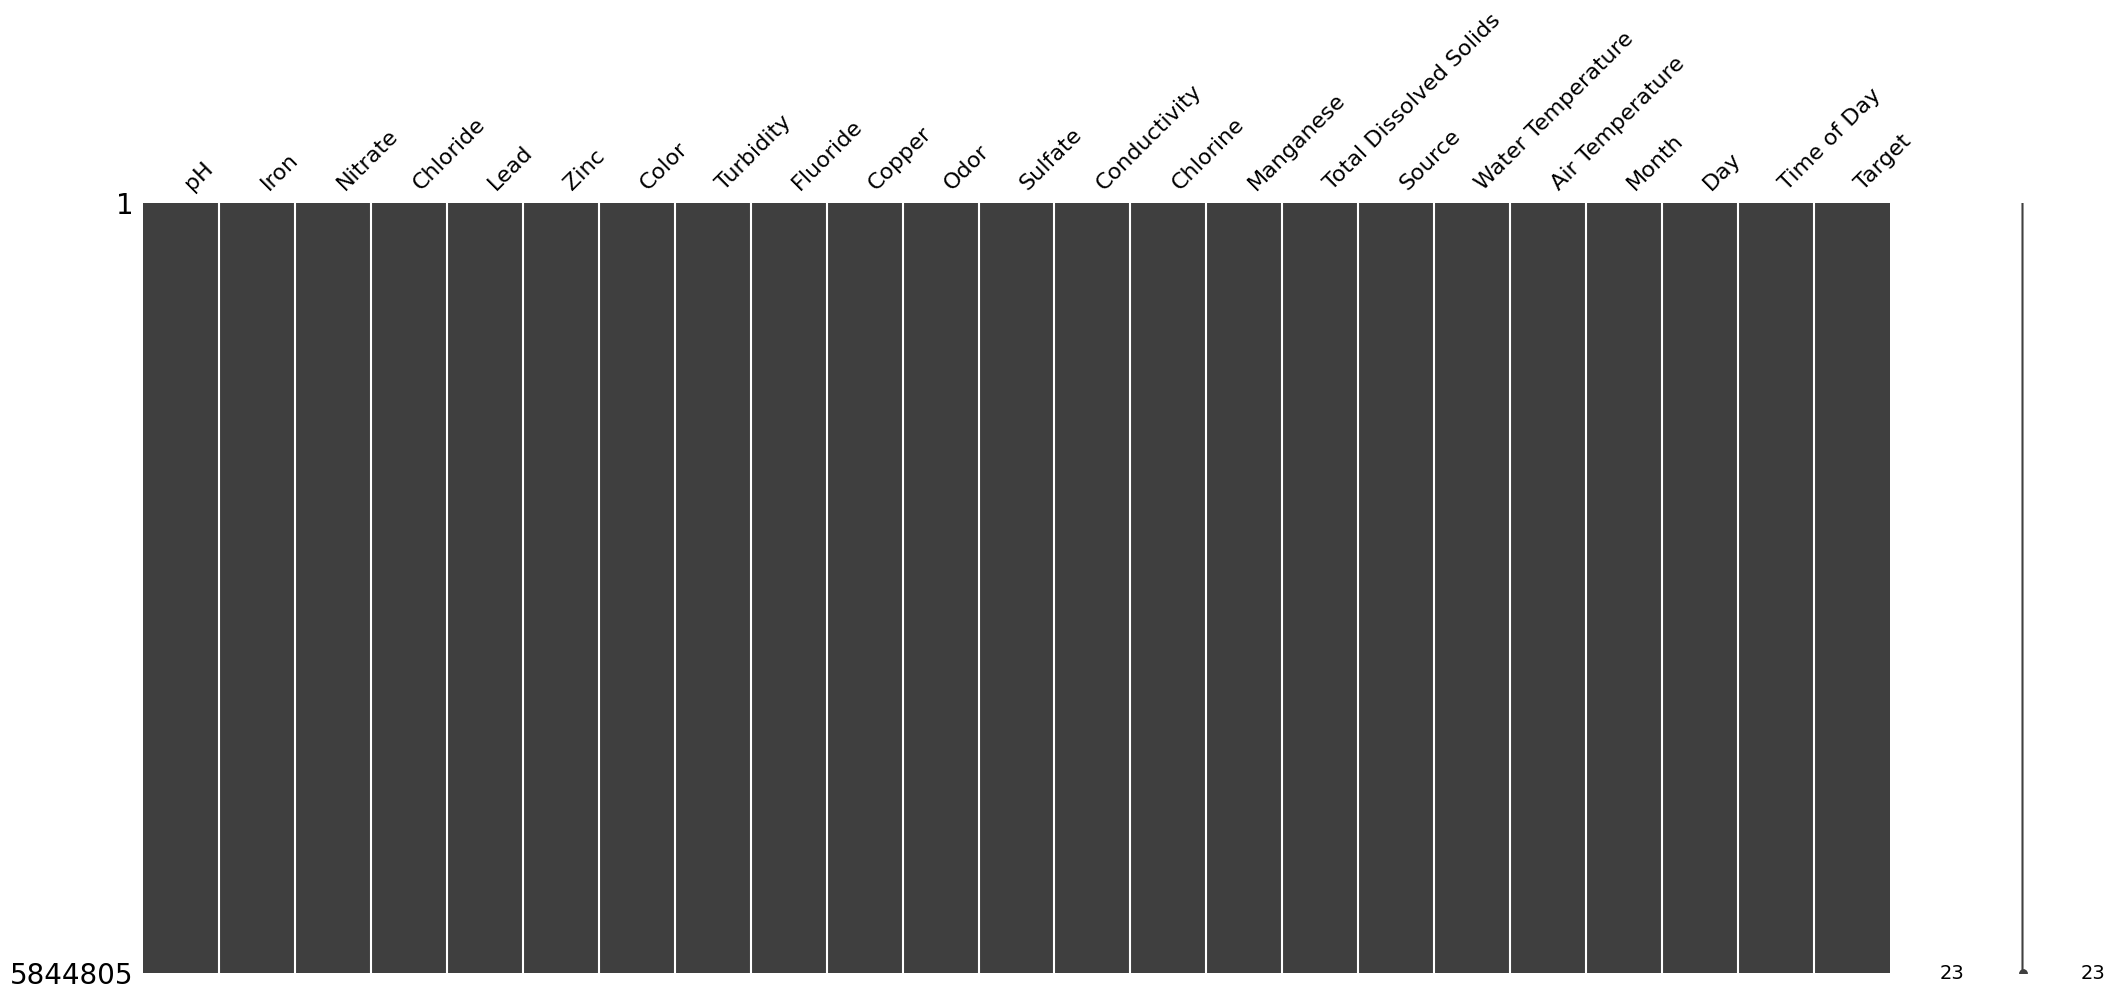

In [5]:
msno.matrix(data)

missing = data.isna().sum().sum()
duplicates = data.duplicated().sum()
print("\nThere are {:,.0f} missing values in the data.".format(missing))
print("There are {:,.0f} duplicate records in the data.".format(duplicates))

display(data.head())

In [6]:
def display_stats():
    
    """
    Function to display descriptive statistics of numerical variables,
    includes skewness & kurtosis.   
    """
    
    df = data.describe()
    skewness = pd.DataFrame(data.skew(numeric_only=True), columns=['skewness']).T
    kurtosis = pd.DataFrame(data.kurt(numeric_only=True), columns=['kurtosis']).T
    df = pd.concat([df, skewness, kurtosis], axis=0)
    display(df.style.format('{:,.3f}').background_gradient(subset=(df.index[1:],df.columns[:]), cmap='GnBu'))

display_stats()

In [7]:
# show target distribution
target=data['Target'].value_counts(normalize=True)
target.rename(index={1:'State 1',0:'State 0'},inplace=True)
fig=go.Figure()
fig.add_trace(go.Pie(labels=target.index, values=target*100, hole=.45, 
                     text=target.index, sort=False, showlegend=False,
                     marker=dict(colors=color,line=dict(color=intel_pal,width=2.5)),
                     hovertemplate = "%{label}: <b>%{value:.2f}%</b><extra></extra>"))
fig.update_layout(template=temp, title='Target Distribution',width=700,height=450,
                  uniformtext_minsize=15, uniformtext_mode='hide')
fig.show() 

In [8]:
cat_cols,float_cols=[],['Target']
for col in data.columns:
    if data[col].value_counts().count() < 10:
        cat_cols.append(col)
    else:
        float_cols.append(col)

/home/u188545/tmp/ipykernel_3187241/4195500069.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



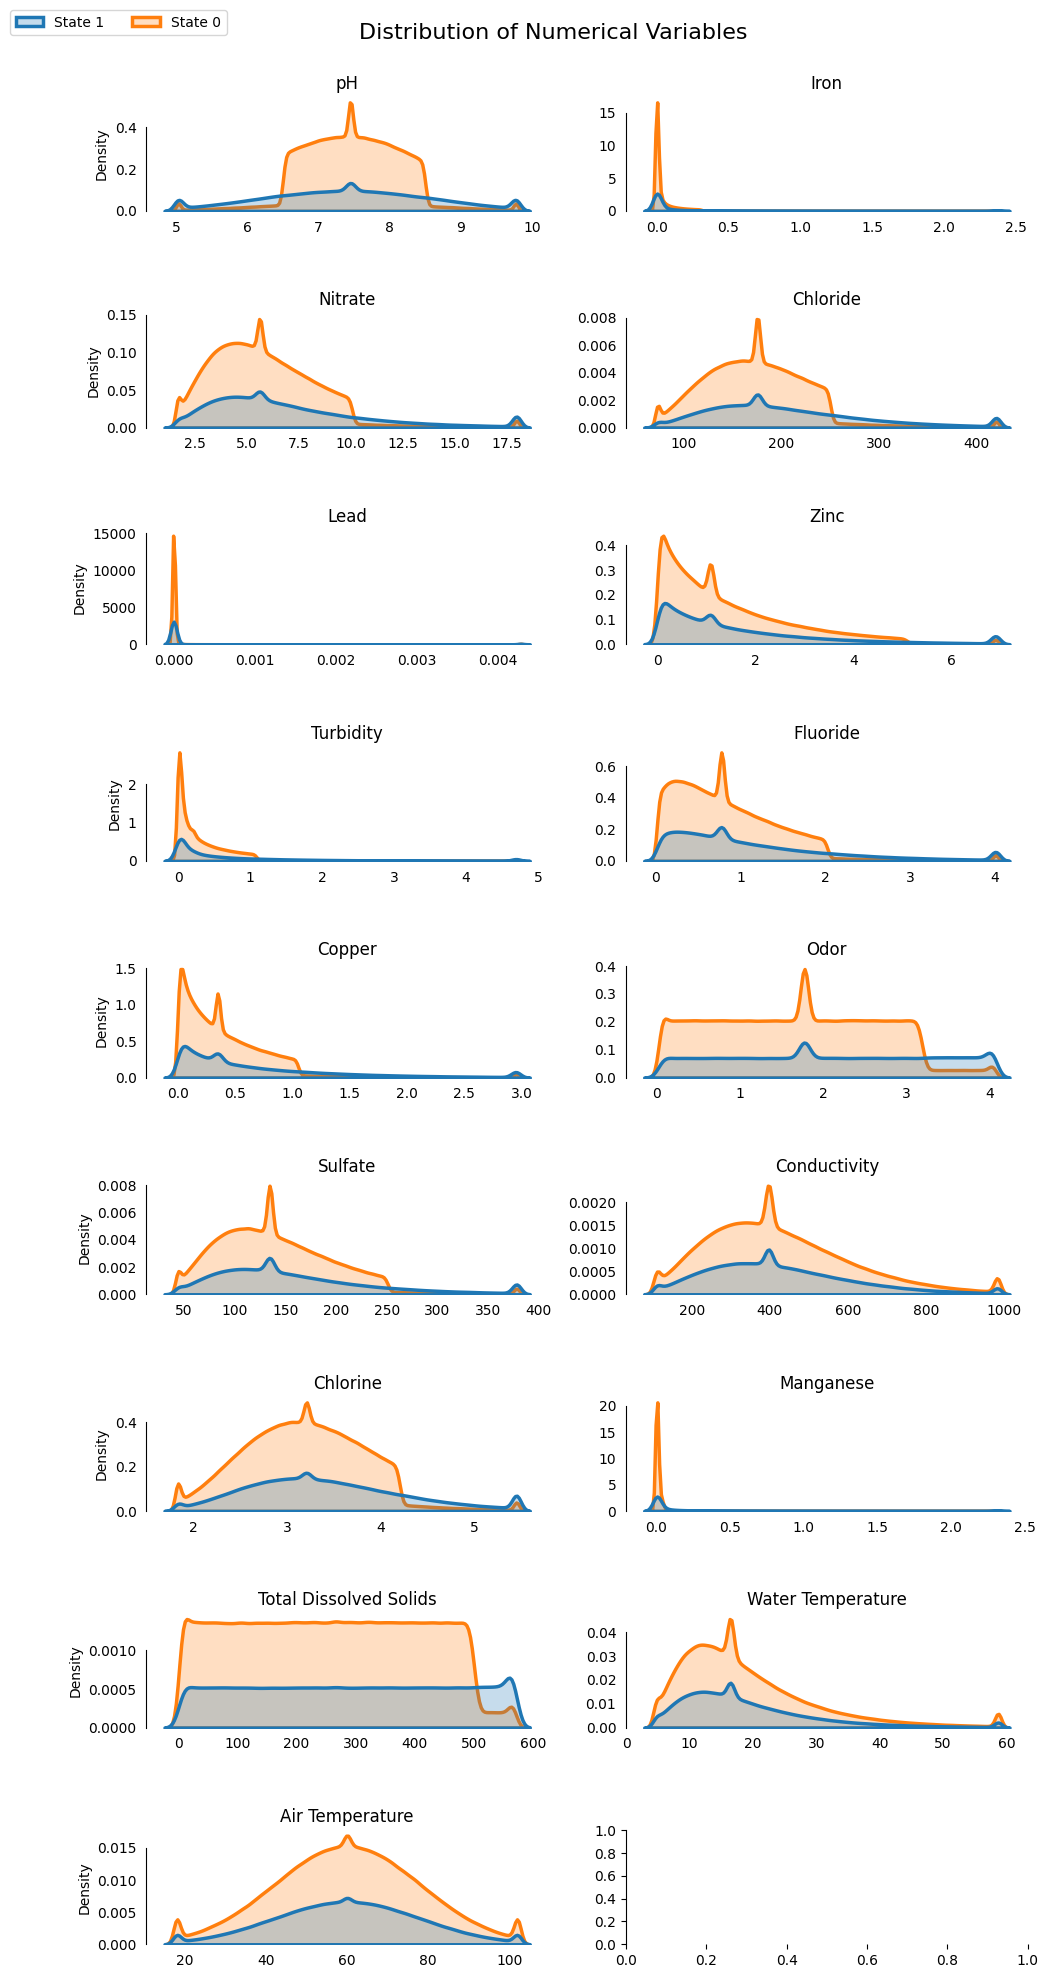

In [9]:
plot_df=data[float_cols]

# do not display distribution with column `Month` and `Day`
columns_to_drop = ['Month', 'Day']
plot_df.drop(columns_to_drop, axis=1, inplace=True)

fig, ax = plt.subplots(9,2, figsize=(10,20))
fig.suptitle('Distribution of Numerical Variables',fontsize=16)
row=0
col=[0,1]*9

for i, column in enumerate(plot_df.columns[1:-1]):
    if (i!=0)&(i%2==0):
        row+=1
    
    sns.kdeplot(
        x=column, hue='Target', hue_order=[1, 0],
        label=['State 1', 'State 0'], data=plot_df,
        fill=True, linewidth=2.5, legend=False, ax=ax[row, col[i]]
    )
    
    ax[row,col[i]].tick_params(left=False, bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%2==0 else ''))

handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['State 1','State 0'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.99))
sns.despine(bottom=True, trim=True)
plt.tight_layout()

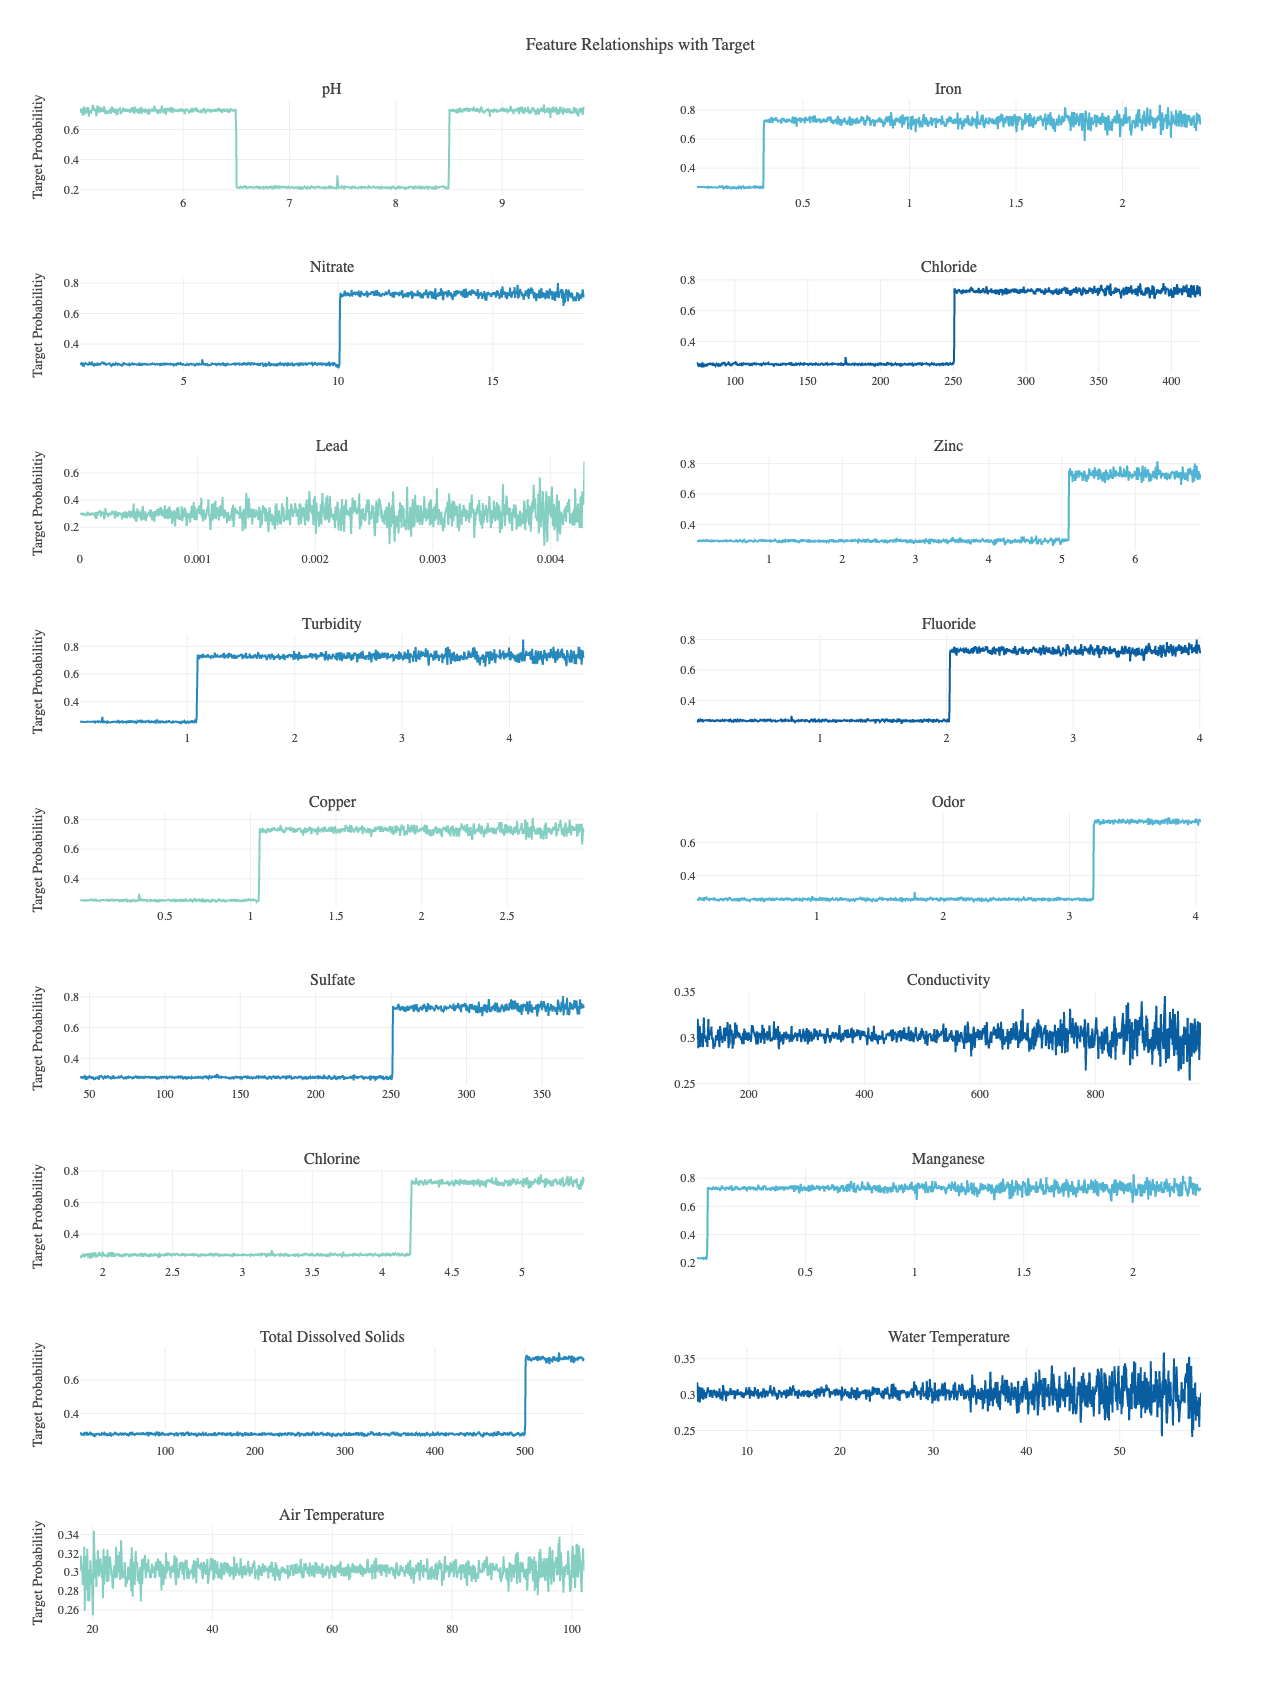

In [10]:
fig=make_subplots(rows=9,cols=2, subplot_titles=float_cols[1:-3])
col=[1,2]*9
row=0
pal=sns.color_palette("GnBu",20).as_hex()[9:][::3]

for i, column in enumerate(data[float_cols].columns[1:-3]):
    if i%2 == 0:
        row += 1
    df = pd.concat([data[column], data['Target']], axis=1)

    df['bins'] = pd.cut(df[column], 1000)
    df['mean'] = df.bins.apply(lambda x: x.mid)

    df = df.groupby('mean')[[column,'Target']].transform('mean')
    df = df.drop_duplicates(subset=[column]).sort_values(by=column)
    
    fig.add_trace(go.Scatter(x=df[column], y=df.Target, name=column,
                             marker_color=pal[i % len(pal)], showlegend=False),
                  row=row, col=col[i])
    fig.update_xaxes(zeroline=False, row=row, col=col[i])
    if i%2 == 0:
        fig.update_yaxes(title='Target Probabilitiy',row=row,col=col[i]) 
fig.update_layout(template=temp, title='Feature Relationships with Target', hovermode="x unified",height=1700,width=1200)
fig.show()

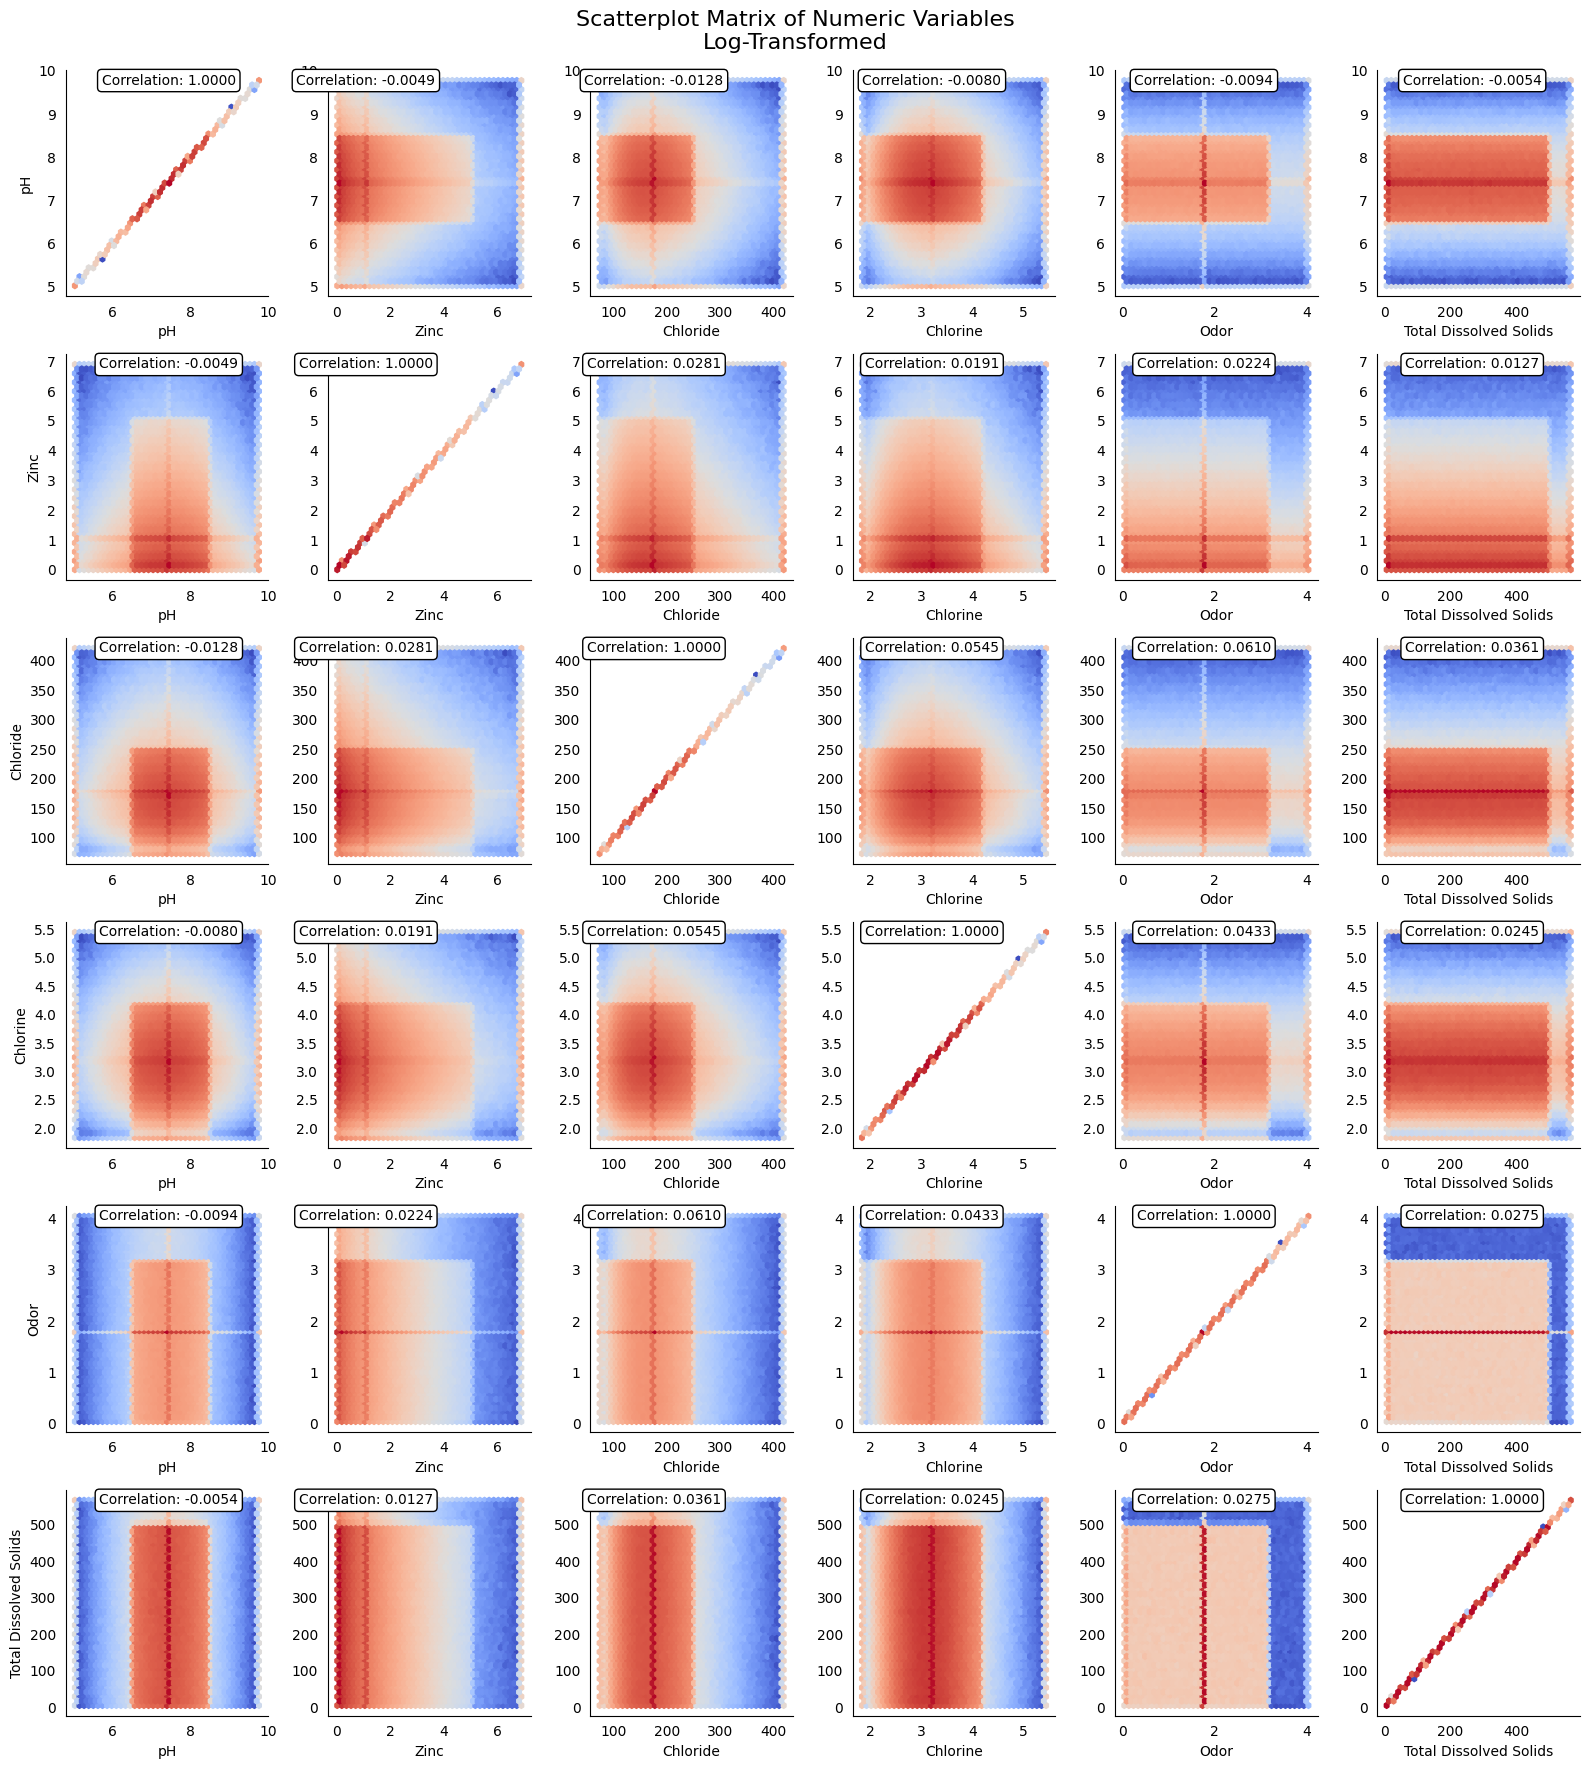

In [11]:
check_cols = ['pH', 'Zinc', 'Chloride', 'Chlorine', 'Odor', 'Total Dissolved Solids']
check_cols_len = len(check_cols)

plot_df=data[check_cols]
fig, ax = plt.subplots(check_cols_len, check_cols_len, figsize=(16,18))
fig.suptitle('Scatterplot Matrix of Numeric Variables\nLog-Transformed',fontsize=16)
for i, col in enumerate(check_cols):
    for j, iter_col in enumerate(check_cols):
        ax[i,j].hexbin(x=iter_col, y=col, data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
        ax[i,j].set(xlabel=iter_col, ylabel=(col if j % check_cols_len == 0 else ''))
        ax[i,j].text(plot_df[iter_col].median(), plot_df[col].max(), 
                     'Correlation: {:.4f}'.format(plot_df[[col,iter_col]].corr().iloc[1,0]), 
                   ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
        ax[i,j].tick_params(left=False,bottom=False)    

sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

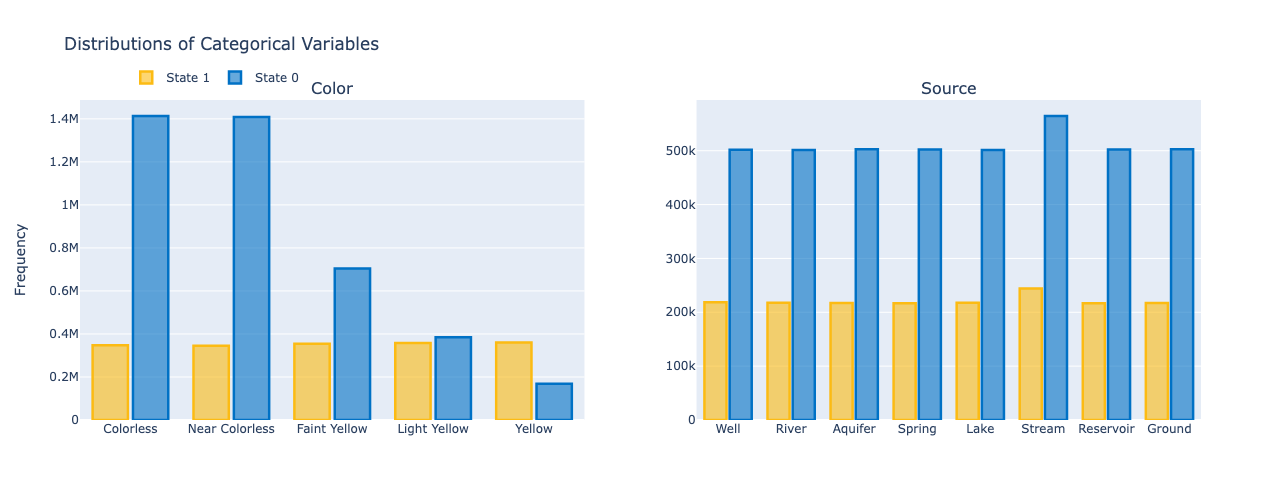

In [12]:
fig = make_subplots(rows=1, cols=2, subplot_titles=[c for c in cat_cols if c!='Target'])
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.6)) for i in intel_pal]
row=0
c=[1,2]*1
for i, col in enumerate(c for c in cat_cols if c!='Target'):
    if i%2==0:
        row+=1
    df=data.groupby(col)['Target'].value_counts().rename('count').reset_index()
    fig.add_trace(go.Bar(x=df[df.Target==1][col].apply(lambda x: mapping[col].get(x, x)), y=df[df.Target==1]['count'],width=.35,
                         marker_color=rgb[1], marker_line=dict(color=intel_pal[1],width=2.5), 
                         hovertemplate='Value: %{x}<br>Count: %{y}',
                         name='State 1', showlegend=(True if i==0 else False)),
                  row=row, col=c[i])
    fig.add_trace(go.Bar(x=df[df.Target==0][col].apply(lambda x: mapping[col].get(x, x)), y=df[df.Target==0]['count'],width=.35,
                         marker_color=rgb[0], marker_line=dict(color=intel_pal[0],width=2.5),
                         hovertemplate='Value: %{x}<br>Count: %{y}',
                         name='State 0', showlegend=(True if i==0 else False)),
                  row=row, col=c[i])
    if i%2==0:
        fig.update_yaxes(title='Frequency',row=row,col=c[i])
fig.update_layout(title="Distributions of Categorical Variables",
                  legend=dict(orientation="h",yanchor="bottom",y=1.025,xanchor="right",x=.2),
                  barmode='group',height=500,width=900)
fig.show()

/home/u188545/tmp/ipykernel_3187241/3676112207.py:34: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



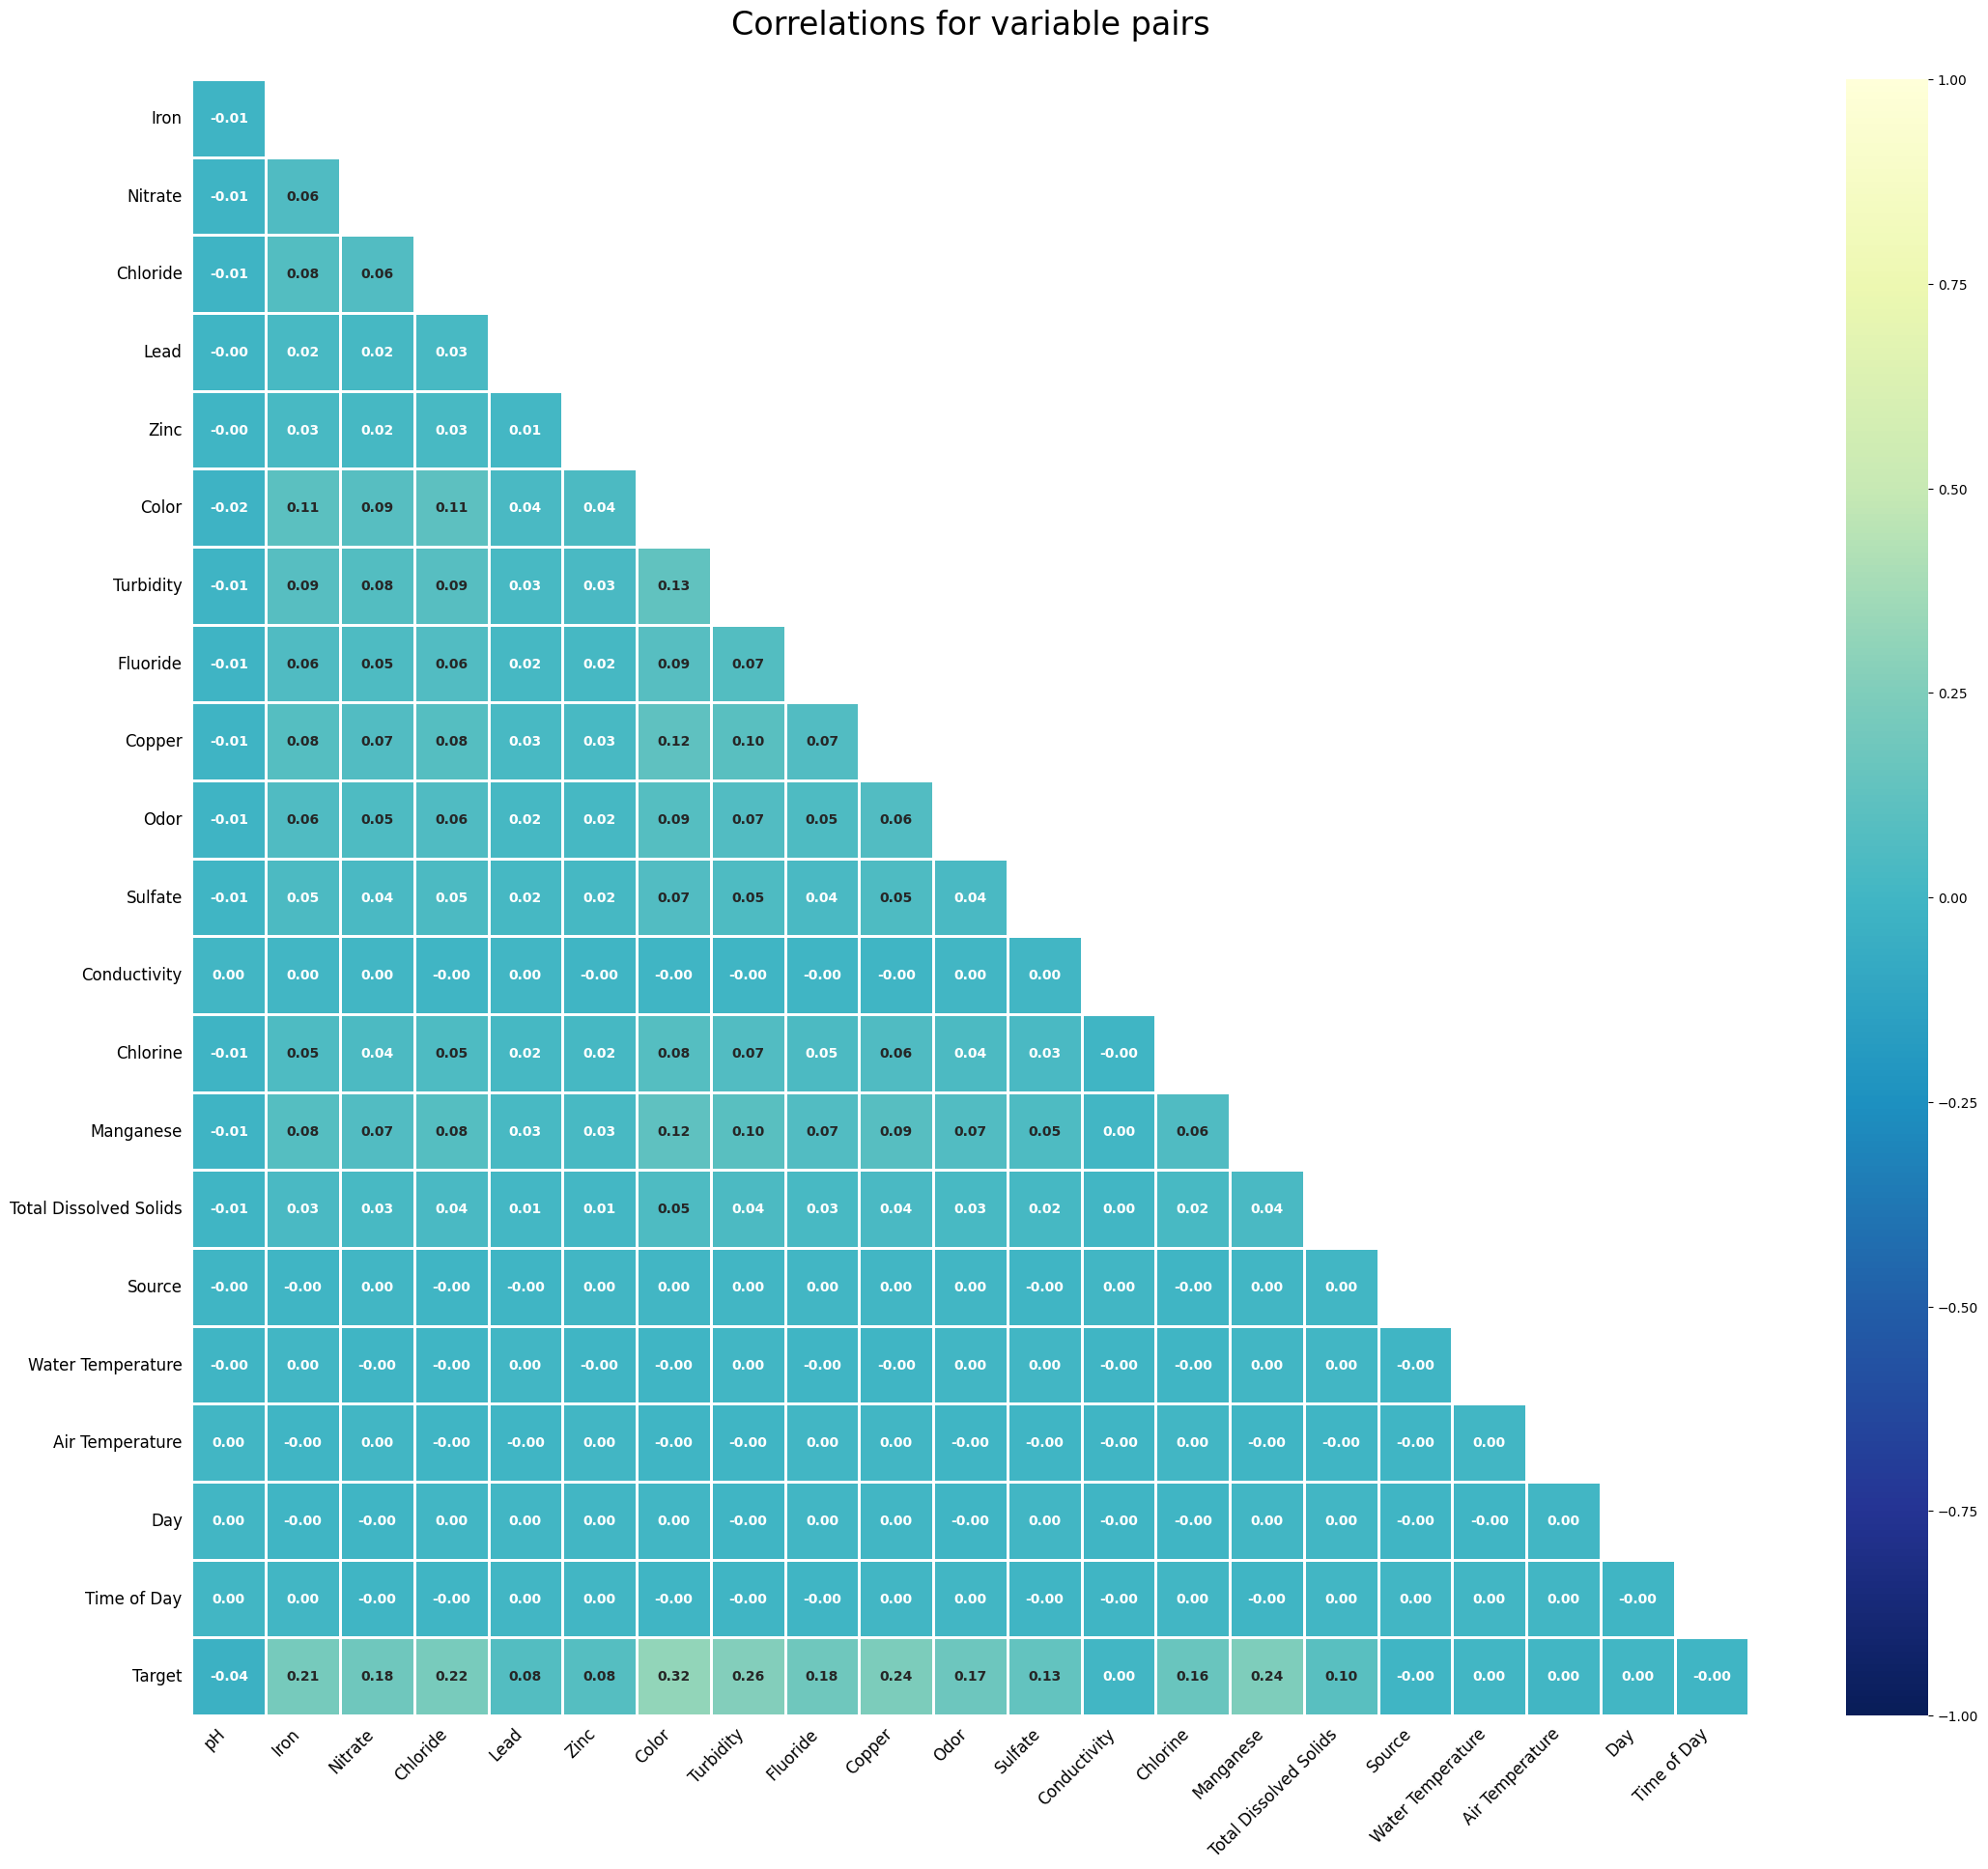

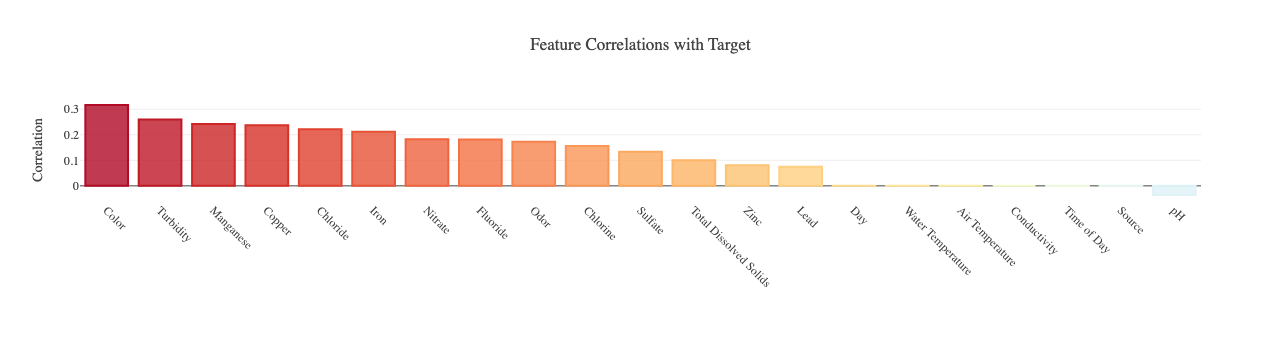

In [13]:
def plot_corr(corr):
    """
    Function to plot bottom left triangle of correlation matrix
    """
    mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
    corr=corr.iloc[1:,:-1].copy()
    fig, ax = plt.subplots(figsize=(26,22))   
    sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
                cmap='YlGnBu_r',lw=2, annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=True)
    ax.tick_params(left=False,bottom=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)
    plt.title('Correlations for variable pairs\n', fontsize=24)
    plt.show()
    
def plot_target_corr(corr, target_col): 
    """
    Function to plot a bar chart of correlations between target and features, sorted in descending order
    """
    corr=corr[target_col].sort_values(ascending=False)[1:]
    pal=sns.color_palette("RdYlBu",37).as_hex()
    pal=[j for i,j in enumerate(pal) if i not in (17,18)]
    rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.8)) for i in pal] 
    
    fig=go.Figure()
    fig.add_trace(go.Bar(x=corr.index, y=corr, marker_color=rgb,
                         marker_line=dict(color=pal,width=2),
                         hovertemplate='%{x} correlation with Target = %{y}',
                         showlegend=False, name=''))
    fig.update_layout(template=temp, title='Feature Correlations with Target', 
                      yaxis_title='Correlation', margin=dict(b=160), xaxis_tickangle=45)
    fig.show()
    
corr=data.corr()
plot_corr(corr=corr)
plot_target_corr(corr=corr, target_col='Target')